<a href="https://colab.research.google.com/github/sonhs99/MachineLearning/blob/master/Assignment10/Assignment10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Assignment09

### 0. Import Library, Get Data

In [0]:
from google.colab import files
import matplotlib.pyplot as plt
import numpy as np
import cupy as cp
import random
from tqdm.auto import tqdm

In [0]:
file_data   = "sample_data/mnist_test.csv"
handle_file = open(file_data, "r")
data        = handle_file.readlines()
handle_file.close()

size_row    = 28    # height of the image
size_col    = 28    # width of the image

num_image   = len(data)
count       = 0     # count for the number of images

#
# normalize the values of the input data to be [0, 1]
#
def normalize(data):

    data_normalized = (data - min(data)) / (max(data) - min(data))

    return(data_normalized)

#
# example of distance function between two vectors x and y
#
def distance(x, y):

    d = (x - y) ** 2
    s = np.sum(d)
    # r = np.sqrt(s)

    return(s)

#
# make a matrix each column of which represents an images in a vector form
#
list_image  = np.empty((size_row * size_col, num_image), dtype=float)
list_labels  = np.empty(num_image, dtype=int)

for line in data:

    line_data   = line.split(',')
    label       = line_data[0]
    im_vector   = np.asfarray(line_data[1:])
    im_vector   = normalize(im_vector)

    list_labels[count]       = label
    list_image[:, count]    = im_vector

    count += 1

list_label = cp.zeros((10, num_image))
for i in range(num_image):
  list_label[list_labels[i]][i] = 1

In [0]:
lamda = 0.5

In [0]:
class Sequence:
    def __init__(self, layers : list, rate, loss = 'binary'):
        self.Layer = layers
        self.Loss = LossSelector(loss)
        self.Rate = rate

    def predict(self, data):
        h = data
        for l in self.Layer:
            h = l.predict(h)
        return h

    def forward(self, data):
        h = data
        for l in self.Layer:
            h = l.forward(h)
        return h    

    def backpropagate(self, a, label):
        sigma = self.Loss.diff(label, a)
        sum = 0
        for l in reversed(self.Layer):
            sigma, a = l.backward(a, sigma, self.Rate)
            sum += (l.Layer * l.Layer).sum()
        return sum / (2 * a.shape[1]) * lamda

    def train(self, data, label, epoch, *test):
        train_e = []
        train_acc = []
        test_e = []
        test_acc = []
        for i in tqdm(range(epoch)):
            h = self.forward(data)
            if len(test) != 0 : t = self.predict(test[0])
            r = self.backpropagate(h, label)
            train_e.append(self.Loss.calc(label, h) + r)
            train_acc.append(accuracy(h.argmax(axis = 0), label))
            if len(test) != 0:
                test_e.append(self.Loss.calc(test[1], t) + r)
                test_acc.append(accuracy(t.argmax(axis = 0), test[1]))

        if len(test) == 0 : return train_e, train_acc
        return train_e, train_acc, test_e, test_acc

class Linear:
    def __init__(self, size, schedule = 'sgd', active = 'sigmoid', bias = False):
        self.size = size
        self.Layer = cp.random.normal(size = (size[0], size[1] + bias), scale = cp.sqrt(2/(size[0] + size[1]))*4)
        self.a = cp.zeros(size[0])
        self.bias = bias
        self.activation = ActivationSelector(active)
        self.scheduler = SchedulerSelector(schedule)

    def forward(self, data):
        self.a = generator(data, self.bias)
        return self.activation.calc(self.Layer@self.a)

    def predict(self, data):
        return self.activation.calc(self.Layer@generator(data, self.bias))

    def backward(self, a, sigma, rate):
        sigma = sigma*self.activation.diff(a)
        dx = sigma@self.a.transpose()/self.a.shape[1] + lamda * self.Layer / a.shape[1]
        t = rate*self.scheduler.grad(dx)
        self.Layer -= t
        return ((self.Layer.transpose()@sigma)[:len(self.a)-self.bias], self.a[:len(self.a)-self.bias])

def accuracy(pred, label):
  return (pred == label.argmax(axis = 0)).mean()

def generator(data, bias):
  return data if not bias else cp.vstack((data, cp.ones((1, data.shape[1]))))


In [0]:
class Sigmoid:
    def __init__(self):
        pass

    def calc(self, x):
        return cp.reciprocal(1 + np.exp(-x))

    def diff(self, a):
        return a*(1 - a)

class ReLU:
    def __init__(self):
        pass

    def calc(self, x):
        return np.maximum(-0.1*x, x)

    def diff(self, x):
        return (x > 0) - (x <= 0)*0.1

def ActivationSelector(active):
    if active == 'sigmoid': return Sigmoid()
    if active == 'relu': return ReLU()
    print('ActivationSelector : not found %s' % active)

In [0]:
class BinaryLoss:
    def __init__(self):
        pass

    def calc(self, label, pred):
        return -((label*cp.log(pred) + (1 - label)*cp.log(1 - pred)).sum(axis=0)).mean()

    def diff(self, label, pred):
        return -label / pred + (1 - label) / (1 - pred)

def LossSelector(loss):
    if loss == 'binary': return BinaryLoss()
    print('LossSelector : not found %s' % loss)

In [0]:
class SGD():
    def __init__(self):
        pass

    def grad(self, dx):
        return dx

class RMSprop():
    beta = 0.9
    eps = 1e-8
    def __init__(self):
        self.cache = None

    def grad(self, dx):
        self.cache = (dx*dx) if self.cache is None else (RMSprop.beta * self.cache + (1 - RMSprop.beta) * dx*dx)
        return dx/(cp.sqrt(self.cache) + RMSprop.eps)

def SchedulerSelector(schedule):
    if schedule == 'sgd': return SGD()
    if schedule == 'rmsprop': return RMSprop()
    print('SchedulerSelector : not found %s' % schedule)

In [0]:
Model = Sequence([Linear((112, 784), active = 'sigmoid', bias = True, schedule = 'rmsprop'),
                  Linear((16, 112),  active = 'sigmoid', bias = True, schedule = 'rmsprop'),
                  Linear((10, 16),   active = 'sigmoid', bias = True, schedule = 'rmsprop')],
                 0.0001, 'binary')

In [9]:
train_e, train_acc, test_e, test_acc= Model.train(list_image[:, :1000], list_label[:, :1000], 15000, list_image[:, 1000:], list_label[:, 1000:])

### 1. Plot the loss

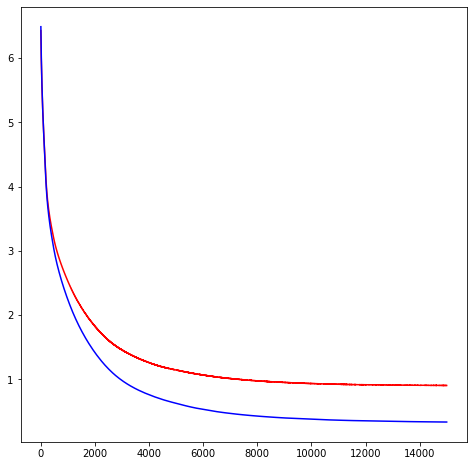

In [10]:
plt.figure(figsize=(8, 8))
plt.plot(range(0, len(test_e)), test_e, c = 'r')
plt.plot(range(0, len(train_e)), train_e, c = 'b')
plt.show()

# 2. Plot the accuracy

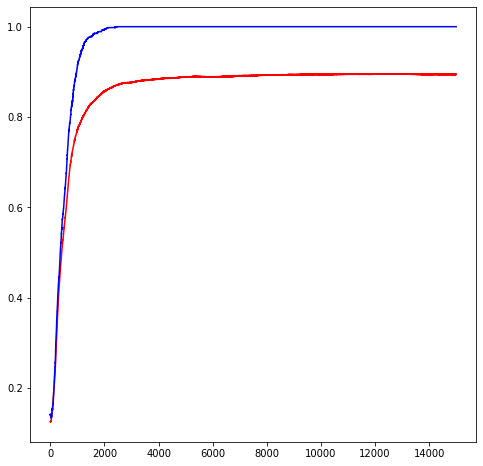

In [11]:
plt.figure(figsize=(8, 8))
plt.plot(range(0, len(test_acc)), test_acc, c = 'r')
plt.plot(range(0, len(train_acc)), train_acc, c = 'b')
plt.show()

### 3. Plot the final accuracy

In [12]:
print('train accuracy :', train_acc[-1]*100, '%')
print('test accuracy :', test_acc[-1]*100, '%')

train accuracy : 100.0 %
test accuracy : 89.42222222222223 %


In [0]:
def print_image(image, label, pred):
  plt.imshow(image)
  plt.xticks([])
  plt.yticks([])
  plt.grid(False)
  plt.xlabel("label : {}\n pred : {}".format(label, pred))

### 4. Plot the classification

* Case : Correct

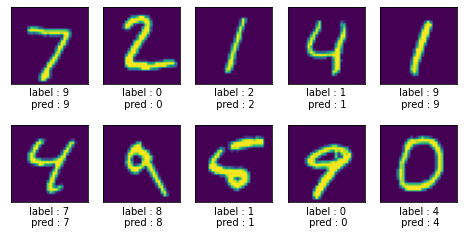

In [20]:
plt.figure(figsize=(8,4))
pred = Model.predict(list_image[:,1000:]).argmax(axis=0)
real = list_labels[1000:]
i = 0
for t in range(len(pred)):
  if pred[t] != real[t]: continue
  if i == 10 : break
  plt.subplot(2,5,i + 1)
  image = list_image.transpose()[t].reshape((28, 28))
  print_image(image, real[t], pred[t])
  i += 1
plt.show()

* Case : Wrong

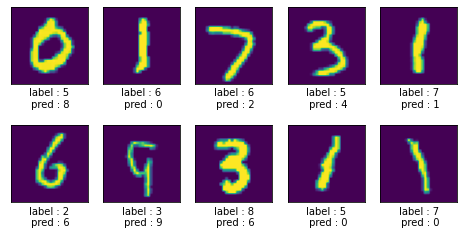

In [21]:
plt.figure(figsize=(8,4))
i = 0
for t in range(len(pred)):
  if pred[t] == real[t]: continue
  if i == 10 : break
  plt.subplot(2,5,i + 1)
  image = list_image.transpose()[t].reshape((28, 28))
  print_image(image, real[t], pred[t])
  i += 1
plt.show()